In [29]:
%reload_ext autoreload
%autoreload 2
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.autograd import Variable
import os

## Import MiniPlaces Dataset

In [30]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image

class MiniPlacesDataset(Dataset): 
    def __init__(self, **kwargs):
        # load in the data 
        self.photos_path = kwargs['photos_path']
        self.labels_path = kwargs['labels_path']
        self.transform = kwargs['transform']
        self.load_size = 224
        self.images = []
        self.labels = []

        # read the text file
        with open(self.labels_path, 'r') as f: 
            for line in f:
                path, label = line.strip().split(" ")
                self.images.append(path)
                self.labels.append(label)


        self.images = np.array(self.images, np.object)
        self.labels = np.array(self.labels, np.int64)
        print("# images found at path '%s': %d" % (self.labels_path, self.images.shape[0]))

    def __len__(self): 
        return len(self.images)

    def __getitem__(self, idx): 
        image = Image.open(os.path.join(self.photos_path, self.images[idx]))
        image = self.transform(image)
        # label is the index of the correct category
        label = self.labels[idx]
        return (image, label)


In [31]:
OBJ_NAMES = [
    'backpack', 'bird', 'dog', 'elephant', 'kite', 'pizza', 'stop_sign',
    'toilet', 'truck', 'zebra'
]
SCENE_NAMES = [
    'bamboo_forest', 'bedroom', 'bowling_alley', 'bus_interior', 'cockpit'
]

In [32]:
import os
#file_names = ["bamboo_forest"]
file_content = []
for i in range(len(SCENE_NAMES)):
    for root, dirs, files in os.walk("/work/lisabdunlap/explain-eval/results/bam/train/"+SCENE_NAMES[i]+"/", topdown=True):
        for img_name in dirs:
            if ('backpack' in img_name or 'bird' in img_name or 'dog' in img_name or 'elephant' in img_name):
                file_content += [root + img_name + "/original_img.npy "+ str(i) + " " + root + img_name + "/gcam-bam_scene.npy\n"]
        #for name in sorted(dirs, files):
            #if name[-3:] == 'png' and 'original' not in name:
            #    print("name {0}  dir {1}".format(direc, name))
            #file_content += ["train/"+ file_names[i]+"/"+name+ " "+str(i) +"\n"]
outF = open("/work/lisabdunlap/explain-eval/results/bam/train.txt", "w+")
outF.writelines(file_content)
outF.close()

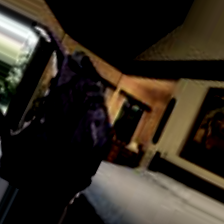

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("/work/lisabdunlap/explain-eval/results/bam/train/bedroom/correct/backpack-bedroom-0000/original_img.png")
img_np = np.load("/work/lisabdunlap/explain-eval/results/bam/train/bedroom/correct/backpack-bedroom-0000/original_img.npy")
new_img = Image.fromarray(np.uint8(img_np))
new_img

## Load Data

In [6]:
data_transforms = {
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

/work/lisabdunlap/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [7]:
data_dir = '/work/lisabdunlap/bam/data/scene/'

dataset = MiniPlacesDataset(
    photos_path=os.path.join(data_dir),
    labels_path=os.path.join(data_dir, 'val2.txt'),
    transform = data_transforms['val']
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True, num_workers=25)

# images found at path '/work/lisabdunlap/bam/data/scene/val2.txt': 10000


try: 8  truth 8
predicted: ski_slope  truth: ski_slope
result path: /work/lisabdunlap/explain-eval/results/bam/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len of attr 46482 and sum 3694 for 0.001
len of attr 47839 and sum 2337 for 0.1
len of attr 48672 and sum 1504 for 0.2
len of attr 46482 and sum 3694 for 0.001
len of attr 47839 and sum 2337 for 0.1
len of attr 48672 and sum 1504 for 0.2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len of attr 45045 and sum 5131 for 0.001
len of attr 46560 and sum 3616 for 0.1
len of attr 47595 and sum 2581 for 0.2
len of attr 45045 and sum 5131 for 0.001
len of attr 46560 and sum 3616 for 0.1
len of attr 47595 and sum 2581 for 0.2
finished Integrated Gradients explanation
------------------------------
0.02


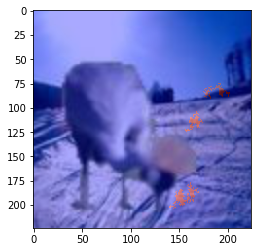

In [20]:
from techniques.generate_grounding import gen_grounding, gen_all_groundings

torch.cuda.set_device(1)
i = 0
output_labels = []
correct =0
for data in data_loader:
    if i<1:
        inputs, labels = data
        inputs = Variable(inputs.float())
        labels = Variable(labels.long())  
        output = model(inputs)    
        probabilities, prediction = output.topk(5, dim=1, largest=True, sorted=True)
        
        for l in range(len(labels)):
            correct=False
            print("try: {0}  truth {1}".format(labels[l], prediction.numpy()[l][0]))
            if labels[l] == prediction.numpy()[l][0]:
                correct = True
        
            img = inputs[l].numpy().transpose((1, 2, 0))
            print("predicted: {0}  truth: {1}".format(SCENE_NAMES[prediction.numpy()[l][0]], SCENE_NAMES[labels.numpy()[l]]))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            displ_img = np.clip((std * img + mean), 0, 1)
            save_img = displ_img/np.max(displ_img)
            displ_img = np.uint8((displ_img/np.max(displ_img))*255)

            grounding = gen_grounding(displ_img, 'ig', SCENE_NAMES[labels.data[0].numpy()], 'bam_scene', save_path='/work/lisabdunlap/explain-eval/results/bam/',
                save=False, correct=correct, show=True)
            break
        i += 1
    else:
        break
print(correct/(i*len(labels)))

In [33]:
i = 0
output_labels = []
correct = 0
for data in data_loader:
    inputs, labels = data
    inputs = Variable(inputs.float())
    labels = Variable(labels.long())  
    output = model(inputs)
    probabilities, prediction = output.topk(5, dim=1, largest=True, sorted=True)
    if prediction.data[0].numpy()[0] == labels.data[0].numpy():
        correct += 1

    print("predicted: {0}  truth: {1}".format(prediction.data[0].numpy()[0], labels.data[0].numpy()))
    i += 1
print("accuracy: {0}".format(correct/i))

predicted: 4  truth: 4
predicted: 5  truth: 5
predicted: 7  truth: 7


KeyboardInterrupt: 